# 02 lifelines

*lifelines is a library mainly for Linear Models and lots of statistical functions. Good starting point, but most of the time will not produce the most accurate models*

* * *

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from lifelines.datasets import load_dd
from lifelines import CoxPHFitter

from src.dd_column_cfg import id_col, drop_cols, cat_cols, num_cols, duration_col, event_col, target_cols

# Data

[Democracy and Dictatorship dataset](https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html#lifelines.datasets.load_dd)

Classification of political regimes as democracy and dictatorship which covers 202 countries from 1946 or year of independence to 2008

In [3]:
data = load_dd()

data = data.reset_index().rename(columns={'index': id_col})
data.democracy = np.where(data.democracy=='Democracy', 1,0)

data.shape

(1808, 13)

In [4]:
data[cat_cols] = data[cat_cols].astype('category')

bin_cols = [n for n,col in data[cat_cols].items() if len(col.cat.categories) <= 2]
cat_cols = list(set(cat_cols) - set(bin_cols))

features = cat_cols + bin_cols + num_cols
col_order = num_cols + cat_cols + bin_cols + target_cols

## Train/Test Split

In [5]:
data_train, data_test = train_test_split(data, test_size=0.2)

data_train.shape, data_test.shape

((1446, 13), (362, 13))

## Transformer

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('target_cat', TargetEncoder())
])

transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('passthrough', 'passthrough', bin_cols + target_cols),
        ('drop', 'drop', drop_cols + [id_col])
    ])

In [7]:
train = transformer.fit_transform(data_train, data_train[duration_col])
test = transformer.transform(data_test)

In [8]:
train = pd.DataFrame(train, columns=col_order)
test = pd.DataFrame(test, columns=col_order)

# Model

In [9]:
cph = CoxPHFitter()
cph.fit(train, duration_col=duration_col, event_col=event_col)

<lifelines.CoxPHFitter: fitted with 1446 total observations, 271 right-censored observations>

In [10]:
y_pred_surv = cph.predict_survival_function(test).round(3)

# Visualize Output

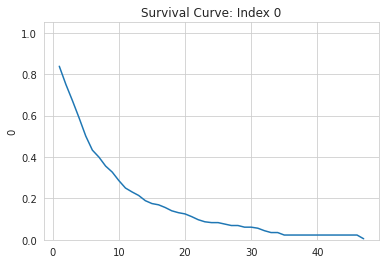

In [11]:
idx=0

sns.lineplot(data=y_pred_surv[idx])
plt.title(f'Survival Curve: Index {idx}')
plt.ylim(0,1.05);

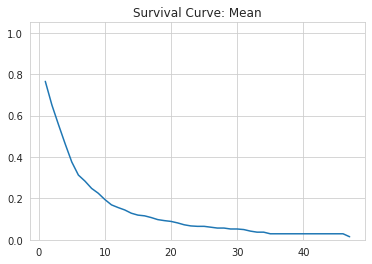

In [12]:
sns.lineplot(data=y_pred_surv.mean(axis=1))
plt.title('Survival Curve: Mean')
plt.ylim(0,1.05);